In [1]:
from hl7apy import parser
from hl7apy.core import Message
import pandas as pd

path = r"D:\stage\data\EXEMPLE2_CAPSULE_HL7_WAVEFORM\exemples capsule waveforms monitoring philips en prod.txt"

In [2]:
# Lire le fichier avec pandas pour vérifier la structure brute
with open(path, 'r') as file:
    content = file.read()
    
print('Contenu du Fichier : \n',content[:1500])

Contenu du Fichier : 
 MSH|^~\&|DATACAPTOR||||20240416152513||ORU^R01|4416152513078d02|P|2.3||||||8859/1|
PID|
PV1||I|LIT5|
OBR|||||||20240416152513|||LIT5|||LIT5|
OBX|1|NA|5141||0.11^0.115^0.12^0.12^0.115^0.11^0.105^0.095^0.09^0.085^0.085^0.085^0.085^0.09^0.09^0.095^0.1^0.105^0.11^0.115^0.12^0.125^0.13^0.13^0.135^0.135^0.135^0.14^0.14^0.14^0.14^0.14^0.135^0.125^0.115^0.105^0.09^0.08^0.065^0.05^0.035^0.025^0.015^0.015^0.01^0.01^0.005^0.005^-0^-0^-0^-0^-0^-0^-0^0.005^0.005^0.005^0.005^0.005^-0^-0.005^-0.01^-0.015^-0.02^-0.025^-0.03^-0.035^-0.035^-0.035^-0.035^-0.03^-0.03^-0.025^-0.025^-0.02^-0.02^-0.02^-0.015^-0.015^-0.015^-0.015^-0.01^-0.005^0.005^0.015^0.04^0.065^0.105^0.155^0.22^0.295^0.38^0.47^0.57^0.67^0.765^0.85^0.915^0.95^0.965^0.955^0.925^0.88^0.815^0.735^0.64^0.545^0.45^0.365^0.295^0.23^0.165^0.115^0.065^0.025^-0.005^-0.03^-0.05^-0.065^-0.08^-0.095^-0.105^-0.11^-0.12^-0.125^-0.13^-0.135|47|||||F||2.0009|20240416152513|
OBX|2|NA|8858||95.3125^94.9375^94.5625^94.1875^93.8125^93.4

In [3]:
# Fonction pour extraire des champs spécifiques 
def extract_fields(fields, indices):
    return [fields[i] if i < len(fields) else '' for i in indices]

In [4]:
# Champs spécifiques à extraire pour chaque segment
msh_indices = [2, 6, 8, 9]
pv1_indices = [3]
obr_indices = [7, 10, 13]
obx_indices = [1, 3, 5, 11, 13, 14]

In [5]:
# Dictionnaire pour simuler un switch-case
segment_extractors = {
    'MSH': lambda fields: extract_fields(fields, msh_indices),
    'PV1': lambda fields: extract_fields(fields, pv1_indices),
    'OBR': lambda fields: extract_fields(fields, obr_indices),
    'OBX': lambda fields: extract_fields(fields, obx_indices),
}

In [19]:
# Découper le fichier en messages
messages = content.strip().split('MSH')
grouped_messages = []

for msg in messages:
    if msg.strip():  # S'assurer que nous ne traitons pas des chaînes vides
        grouped_messages.append('MSH' + msg)

# Extraire des champs spécifiques et les organiser dans un DataFrame
data = []

for message in grouped_messages:
    segments = message.strip().split('\n')
    message_data = {}
    for segment in segments:
        fields = segment.split('|')
        segment_type = fields[0]
        if segment_type in segment_extractors:
            extracted_fields = segment_extractors[segment_type](fields)
            if segment_type == 'PV1' or segment_type == 'OBX':
                if segment_type not in message_data:
                    message_data[segment_type] = [[] for _ in range(len(extracted_fields))]
                for i, field in enumerate(extracted_fields):
                    message_data[segment_type][i].append(field)
            else:
                message_data[segment_type] = extracted_fields
    data.append(message_data)

# Convertir les données en DataFrame
dfs = []
for message_data in data:
    df_dict = {}
    for segment_type, segments in message_data.items():
        if segment_type in ['PV1', 'OBX']:
            for i, field_values in enumerate(segments):
                key = f'{segment_type}_{i}'
                df_dict[key] = field_values
        else:
            for i, value in enumerate(segments):
                df_dict[f'{segment_type}_{i}'] = value
    dfs.append(pd.DataFrame([df_dict]))

# Combiner tous les DataFrames en un seul
final_df = pd.concat(dfs, ignore_index=True)

# Afficher le DataFrame final
display(final_df)

MSH_0           MSH_1    MSH_2             MSH_3    PV1_0  \
0     DATACAPTOR  20240416152513  ORU^R01  4416152513078d02   [LIT5]   
1     DATACAPTOR  20240416152513  ORU^R01  4416152513109d12   [LIT6]   
2     DATACAPTOR  20240416152513  ORU^R01  4416152513168d22   [LIT7]   
3     DATACAPTOR  20240416152513  ORU^R01  4416152513281d32   [LIT5]   
4     DATACAPTOR  20240416152513  ORU^R01  4416152513710d42   [LIT6]   
...          ...             ...      ...               ...      ...   
2680  DATACAPTOR  20240416153040  ORU^R01  4416153040693b42   [LIT6]   
2681  DATACAPTOR  20240416153040  ORU^R01  4416153040763b52  [LIT14]   
2682  DATACAPTOR  20240416153040  ORU^R01  4416153040765b62   [LIT7]   
2683  DATACAPTOR  20240416153040  ORU^R01  4416153040856b72   [LIT5]   
2684  DATACAPTOR  20240416153040  ORU^R01  4416153040962b82   [LIT7]   

               OBR_0  OBR_1  OBR_2            OBX_0  \
0     20240416152513   LIT5   LIT5        [1, 2, 3]   
1     20240416152513   LIT6   LIT6  [1, 2, 3, 4, 5]   
2     20240416152513   LIT7   LIT7  [1, 2, 3, 4, 5]   
3     20240416152513   LIT5   LIT5        [1, 2, 3]   
4     20240416152513   LIT6   LIT6  [1, 2, 3, 4, 5]   
...              ...    ...    ...              ...   
2680  20240416153040   LIT6   LIT6  [1, 2, 3, 4, 5]   
2681  20240416153040  LIT14  LIT14  [1, 2, 3, 4, 5]   
2682  20240416153040   LIT7   LIT7  [1, 2, 3, 4, 5]   
2683  20240416153040   LIT5   LIT5        [1, 2, 3]   
2684  20240416153040   LIT7   LIT7  [1, 2, 3, 4, 5]   

                              OBX_1  \
0                [5141, 8858, 8870]   
1     [113, 5141, 5142, 8857, 8870]   
2     [113, 5141, 5142, 8857, 8870]   
3                [5141, 8858, 8870]   
4     [113, 5141, 5142, 8857, 8870]   
...                             ...   
2680  [113, 5141, 5142, 8857, 8870]   
2681  [113, 5141, 5142, 8857, 8870]   
2682  [113, 5141, 5142, 8857, 8870]   
2683             [5141, 8858, 8870]   
2684  [113, 5141, 5142, 8857, 8870]   

                                                  OBX_2            OBX_3  \
0     [0.11^0.115^0.12^0.12^0.115^0.11^0.105^0.095^0...        [F, F, F]   
1     [1394^1483^1575^1667^1757^1843^1923^1997^2066^...  [F, F, F, F, F]   
2     [3580^3428^3304^3172^3041^2872^2784^2724^2683^...  [F, F, F, F, F]   
3     [-0.135^-0.135^-0.13^-0.13^-0.125^-0.12^-0.115...        [F, F, F]   
4     [2243^2228^2213^2200^2187^2175^2163^2151^2138^...  [F, F, F, F, F]   
...                                                 ...              ...   
2680  [2592^2561^2531^2501^2471^2441^2412^2382^2352^...  [F, F, F, F, F]   
2681  [2213^2211^2209^2206^2202^2198^2193^2186^2176^...  [F, F, F, F, F]   
2682  [1272^1253^1233^1212^1191^1175^1171^1186^1227^...  [F, F, F, F, F]   
2683  [0.045^0.05^0.05^0.045^0.045^0.035^0.03^0.02^0...        [F, F, F]   
2684  [2242^2173^2109^2050^1996^1948^1905^1867^1833^...  [F, F, F, F, F]   

                                          OBX_4  \
0                     [2.0009, 8.0036, 16.0072]   
1     [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
2     [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
3                     [2.0009, 8.0036, 16.0072]   
4     [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
...                                         ...   
2680  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
2681  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
2682  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
2683                  [2.0009, 8.0036, 16.0072]   
2684  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   

                                                  OBX_5  
0      [20240416152513, 20240416152513, 20240416152513]  
1     [20240416152513, 20240416152513, 2024041615251...  
2     [20240416152513, 20240416152513, 2024041615251...  
3      [20240416152513, 20240416152513, 20240416152513]  
4     [20240416152513, 20240416152513, 2024041615251...  
...                                                 ...  
2680  [20240416153040, 20240416153040, 2024041615304...  
2681  [20240416153040, 202

In [20]:
final_df.columns

Index(['MSH_0', 'MSH_1', 'MSH_2', 'MSH_3', 'PV1_0', 'OBR_0', 'OBR_1', 'OBR_2',
       'OBX_0', 'OBX_1', 'OBX_2', 'OBX_3', 'OBX_4', 'OBX_5'],
      dtype='object')

In [21]:
# Renomer les noms de colonnes
columns_rename = {'MSH_0' : 'SENDING_APPLICATION', 'MSH_1' : 'DATE_TIME_OF_MESSAGE', 'MSH_2' : 'MESSAGE_TYPE', 'MSH_3' : 'MESSAGE_CONTROL_ID', 
                  'PV1_0' : 'ASSIGNED_PATIENT_LOCATION', 
                  'OBR_0' : 'OBSERVATION_DATE_TIME', 'OBR_1' : 'COLLECTOR_IDENTIFIER', 'OBR_2' : 'RELEVANT_CLINICAL_INFORMATION', 
                  'OBX_0' : 'SET_ID_OBX', 'OBX_1' : 'OBSERVATION_IDENTIFIER', 'OBX_2' : 'OBSERVATION_VALUE', 'OBX_3' :'OBSERV_RESULT_STATUS', 'OBX_4' : 'USER_DEFINED_ACCESS_CHECKS', 'OBX_5' : 'DATE_TIME_OF_THE_OBSERVATION'
                 }
final_df.rename(columns=columns_rename, inplace=True)
final_df.head()

SENDING_APPLICATION DATE_TIME_OF_MESSAGE MESSAGE_TYPE MESSAGE_CONTROL_ID  \
0          DATACAPTOR       20240416152513      ORU^R01   4416152513078d02   
1          DATACAPTOR       20240416152513      ORU^R01   4416152513109d12   
2          DATACAPTOR       20240416152513      ORU^R01   4416152513168d22   
3          DATACAPTOR       20240416152513      ORU^R01   4416152513281d32   
4          DATACAPTOR       20240416152513      ORU^R01   4416152513710d42   

  ASSIGNED_PATIENT_LOCATION OBSERVATION_DATE_TIME COLLECTOR_IDENTIFIER  \
0                    [LIT5]        20240416152513                 LIT5   
1                    [LIT6]        20240416152513                 LIT6   
2                    [LIT7]        20240416152513                 LIT7   
3                    [LIT5]        20240416152513                 LIT5   
4                    [LIT6]        20240416152513                 LIT6   

  RELEVANT_CLINICAL_INFORMATION       SET_ID_OBX  \
0                          LIT5        [1, 2, 3]   
1                          LIT6  [1, 2, 3, 4, 5]   
2                          LIT7  [1, 2, 3, 4, 5]   
3                          LIT5        [1, 2, 3]   
4                          LIT6  [1, 2, 3, 4, 5]   

          OBSERVATION_IDENTIFIER  \
0             [5141, 8858, 8870]   
1  [113, 5141, 5142, 8857, 8870]   
2  [113, 5141, 5142, 8857, 8870]   
3             [5141, 8858, 8870]   
4  [113, 5141, 5142, 8857, 8870]   

                                   OBSERVATION_VALUE OBSERV_RESULT_STATUS  \
0  [0.11^0.115^0.12^0.12^0.115^0.11^0.105^0.095^0...            [F, F, F]   
1  [1394^1483^1575^1667^1757^1843^1923^1997^2066^...      [F, F, F, F, F]   
2  [3580^3428^3304^3172^3041^2872^2784^2724^2683^...      [F, F, F, F, F]   
3  [-0.135^-0.135^-0.13^-0.13^-0.125^-0.12^-0.115...            [F, F, F]   
4  [2243^2228^2213^2200^2187^2175^2163^2151^2138^...      [F, F, F, F, F]   

                  USER_DEFINED_ACCESS_CHECKS  \
0                  [2.0009, 8.0036, 16.0072]   
1  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
2  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   
3                  [2.0009, 8.0036, 16.0072]   
4  [8.0036, 2.0009, 2.0009, 8.0036, 16.0072]   

                        DATE_TIME_OF_THE_OBSERVATION  
0   [20240416152513, 20240416152513, 20240416152513]  
1  [20240416152513, 20240416152513, 2024041615251...  
2  [20240416152513, 20240416152513, 2024041615251...  
3   [20240416152513, 20240416152513, 20240416152513]  
4  [20240416152513, 20240416152513, 2024041615251...

In [22]:
final_df.to_csv(r"D:\stage\data_sauvegarde\data_convert_dataframe.csv", index=False)

In [26]:
# Récupérer les lignes relatives à un lit donnée 
data_lit_5 = final_df[final_df['COLLECTOR_IDENTIFIER'] == 'LIT5']
data_lit_5.head()

SENDING_APPLICATION DATE_TIME_OF_MESSAGE MESSAGE_TYPE MESSAGE_CONTROL_ID  \
0           DATACAPTOR       20240416152513      ORU^R01   4416152513078d02   
3           DATACAPTOR       20240416152513      ORU^R01   4416152513281d32   
5           DATACAPTOR       20240416152513      ORU^R01   4416152513880d52   
9           DATACAPTOR       20240416152514      ORU^R01   4416152514081d92   
15          DATACAPTOR       20240416152515      ORU^R01   4416152515068df2   

   ASSIGNED_PATIENT_LOCATION OBSERVATION_DATE_TIME COLLECTOR_IDENTIFIER  \
0                     [LIT5]        20240416152513                 LIT5   
3                     [LIT5]        20240416152513                 LIT5   
5                     [LIT5]        20240416152513                 LIT5   
9                     [LIT5]        20240416152514                 LIT5   
15                    [LIT5]        20240416152515                 LIT5   

   RELEVANT_CLINICAL_INFORMATION SET_ID_OBX OBSERVATION_IDENTIFIER  \
0                           LIT5  [1, 2, 3]     [5141, 8858, 8870]   
3                           LIT5  [1, 2, 3]     [5141, 8858, 8870]   
5                           LIT5  [1, 2, 3]     [5141, 8858, 8870]   
9                           LIT5  [1, 2, 3]     [5141, 8858, 8870]   
15                          LIT5  [1, 2, 3]     [5141, 8858, 8870]   

                                    OBSERVATION_VALUE OBSERV_RESULT_STATUS  \
0   [0.11^0.115^0.12^0.12^0.115^0.11^0.105^0.095^0...            [F, F, F]   
3   [-0.135^-0.135^-0.13^-0.13^-0.125^-0.12^-0.115...            [F, F, F]   
5   [-0.01^-0.005^-0^0.01^0.02^0.03^0.04^0.05^0.06...            [F, F, F]   
9   [-0.17^-0.185^-0.195^-0.205^-0.21^-0.215^-0.21...            [F, F, F]   
15  [0.095^0.095^0.095^0.09^0.09^0.085^0.085^0.08^...            [F, F, F]   

   USER_DEFINED_ACCESS_CHECKS  \
0   [2.0009, 8.0036, 16.0072]   
3   [2.0009, 8.0036, 16.0072]   
5   [2.0009, 8.0036, 16.0072]   
9   [2.0009, 8.0036, 16.0072]   
15  [2.0009, 8.0036, 16.0072]   

                        DATE_TIME_OF_THE_OBSERVATION  
0   [20240416152513, 20240416152513, 20240416152513]  
3   [20240416152513, 20240416152513, 20240416152513]  
5   [20240416152513, 20240416152513, 20240416152513]  
9   [20240416152514, 20240416152514, 20240416152514]  
15  [20240416152515, 20240416152515, 20240416152515]

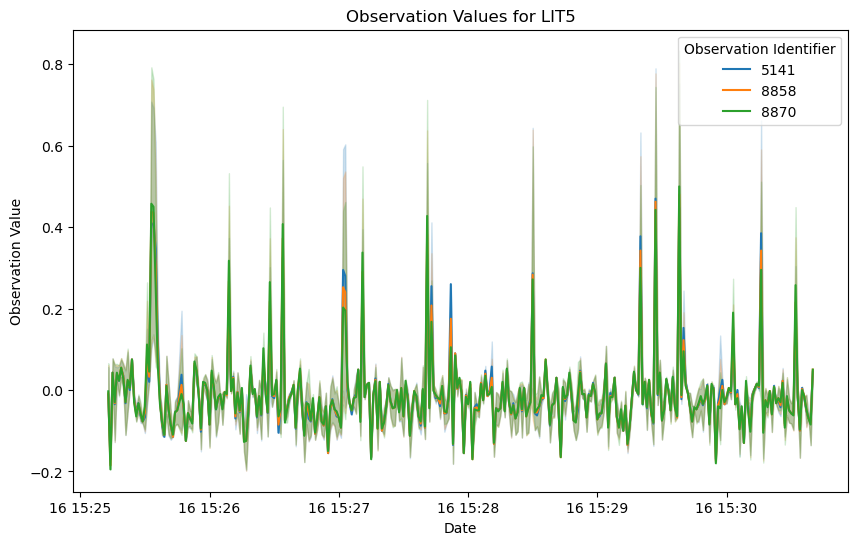

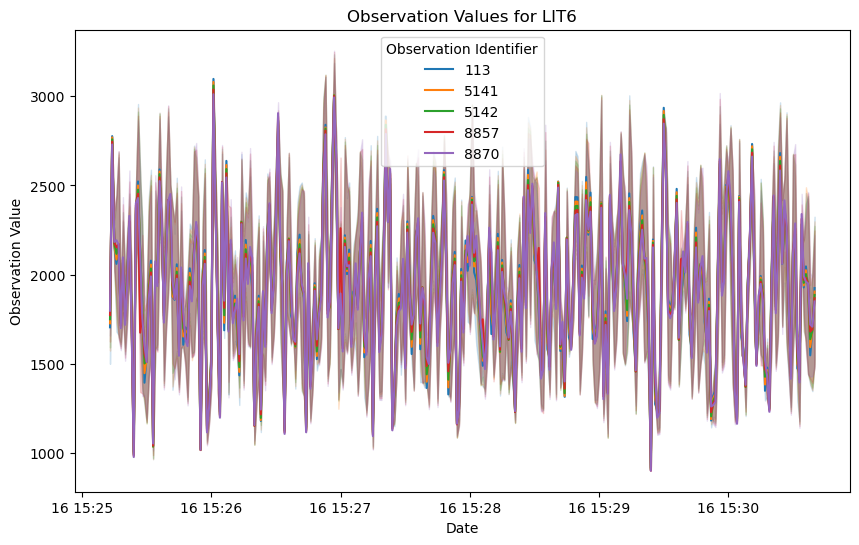

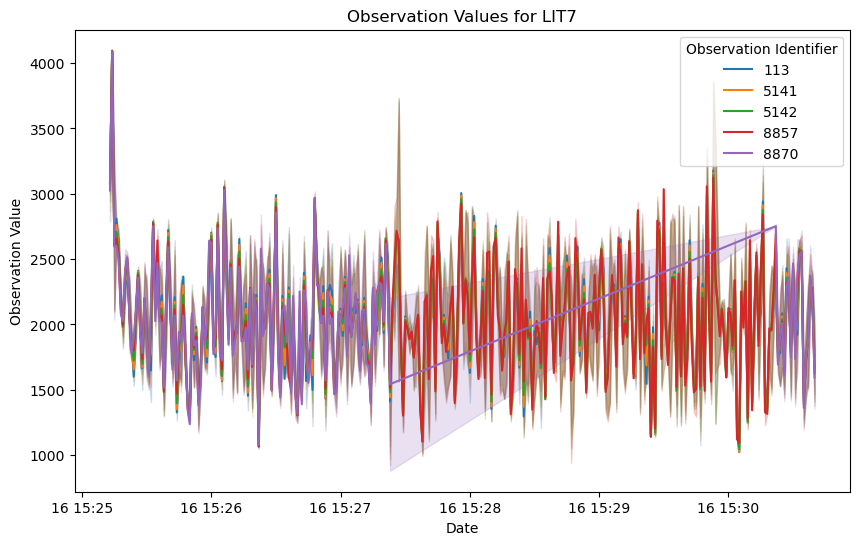

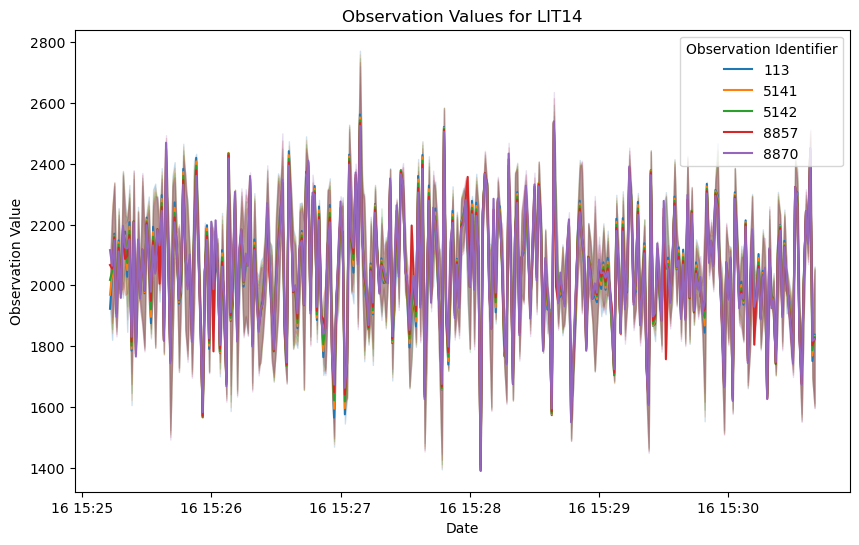

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

df = final_df

# Fonction pour aplatir les listes et créer un nouveau DataFrame
def flatten_dataframe(df):
    records = []
    for idx, row in df.iterrows():
        dates = row['DATE_TIME_OF_THE_OBSERVATION']
        observation_values_list = '^'.join(row['OBSERVATION_VALUE'])

        observation_identifiers = row['OBSERVATION_IDENTIFIER']
        
        for date in dates:
            split_values = observation_values_list.split('^')
            for obs_id, value in zip(observation_identifiers, split_values):
                records.append({
                    'COLLECTOR_IDENTIFIER': row['COLLECTOR_IDENTIFIER'],
                    'DATE_TIME_OF_THE_OBSERVATION': pd.to_datetime(date),
                    'OBSERVATION_IDENTIFIER': obs_id,
                    'OBSERVATION_VALUE': float(value)
                })
    return pd.DataFrame(records)


flattened_df = flatten_dataframe(df)

# Tracer les graphes pour chaque lit et chaque "OBSERVATION_IDENTIFIER"
for collector in flattened_df['COLLECTOR_IDENTIFIER'].unique():
    df_collector = flattened_df[flattened_df['COLLECTOR_IDENTIFIER'] == collector]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='DATE_TIME_OF_THE_OBSERVATION', y='OBSERVATION_VALUE', hue='OBSERVATION_IDENTIFIER', data=df_collector)
    
    plt.title(f'Observation Values for {collector}')
    plt.xlabel('Date')
    plt.ylabel('Observation Value')
    plt.legend(title='Observation Identifier')
    plt.show()

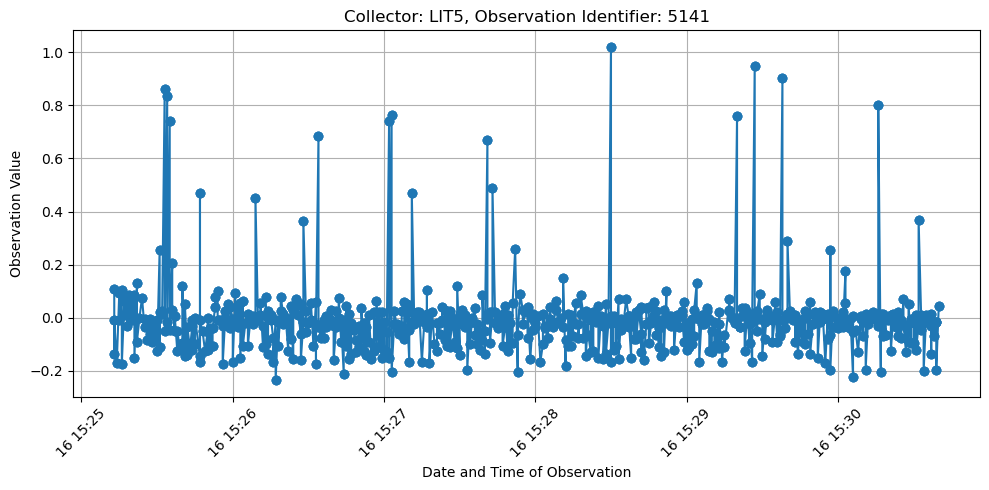

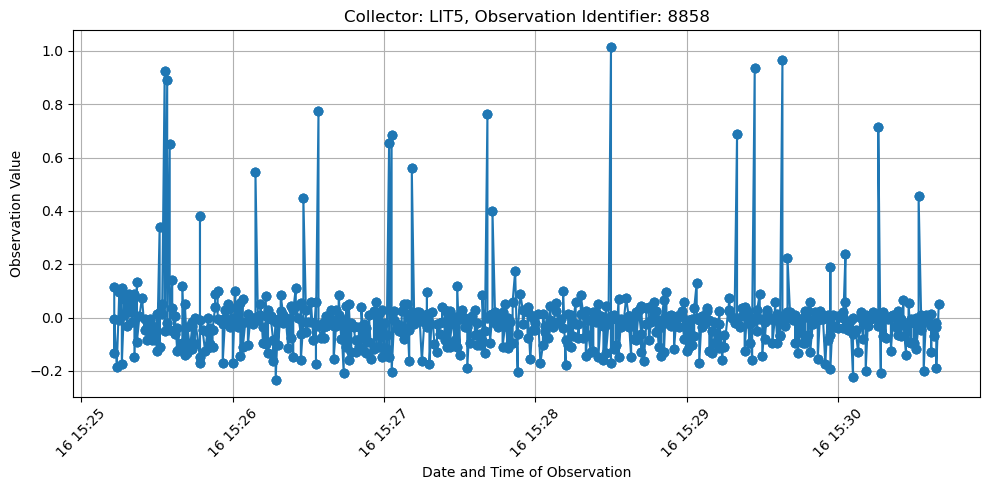

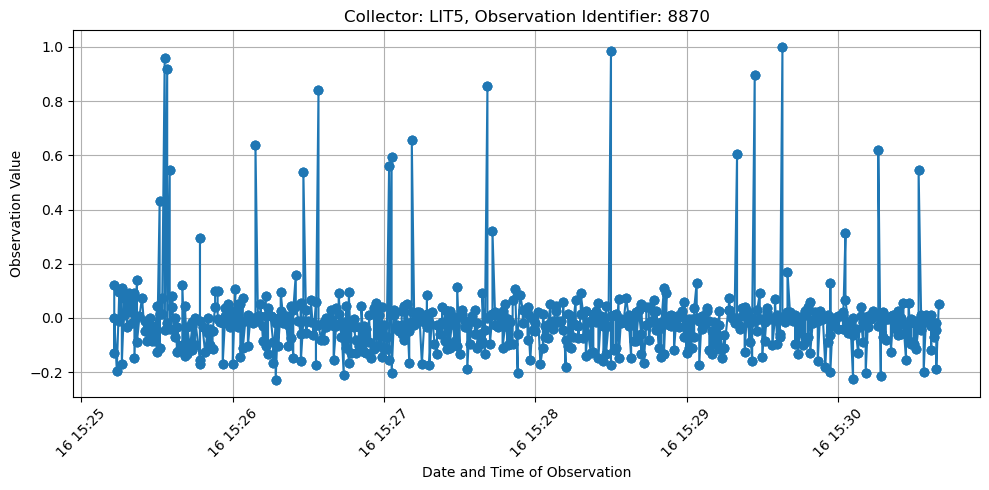

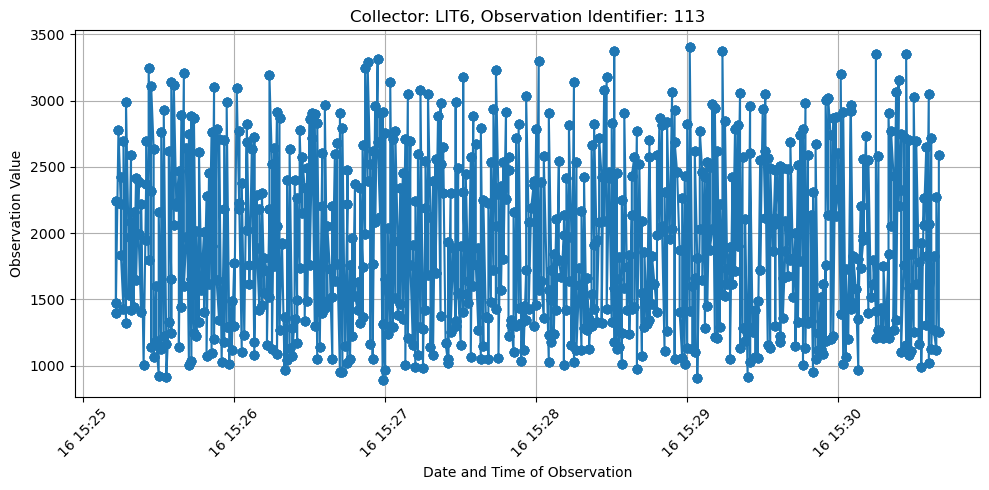

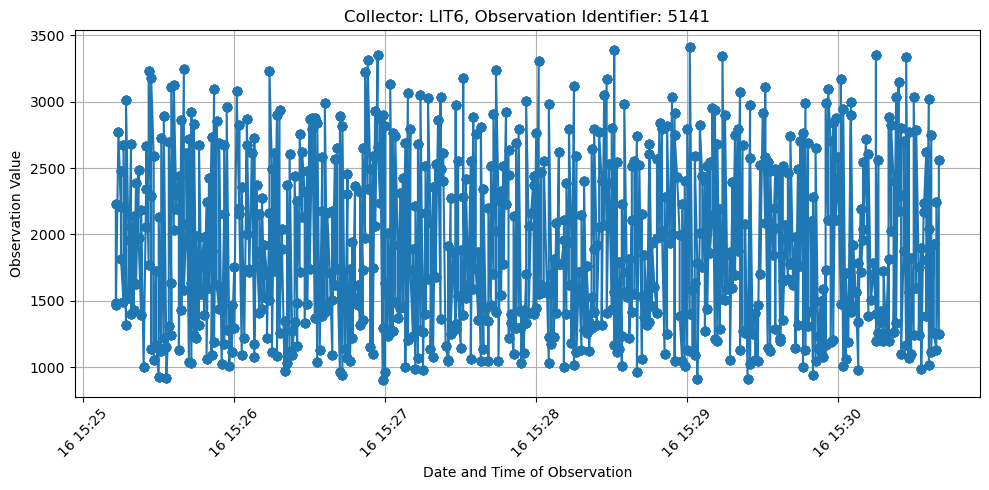

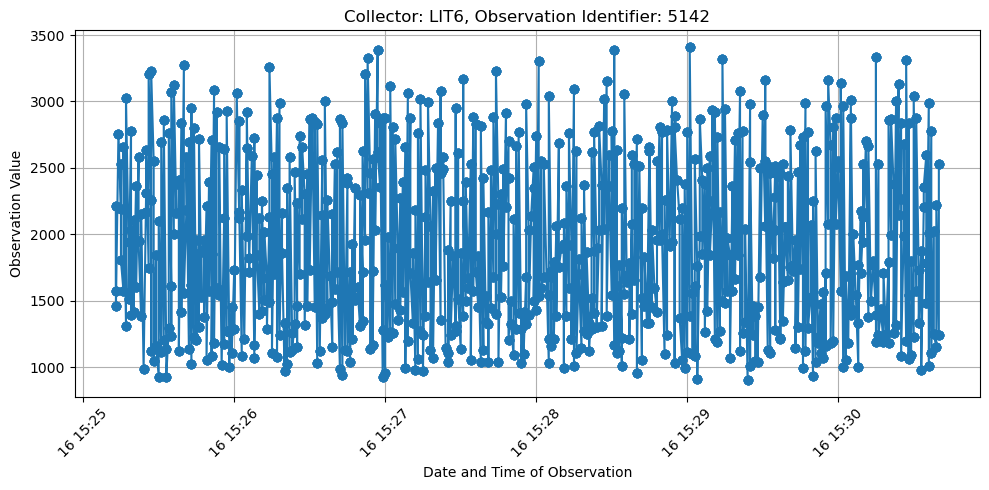

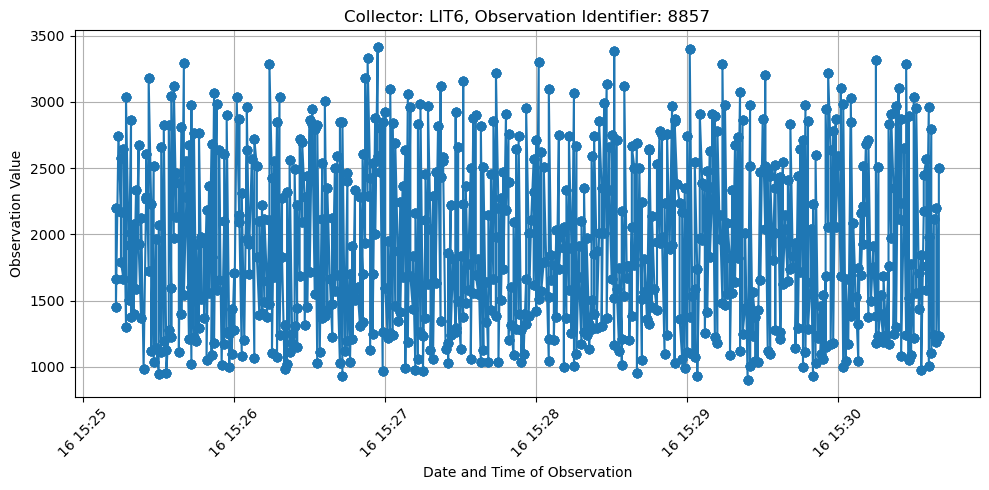

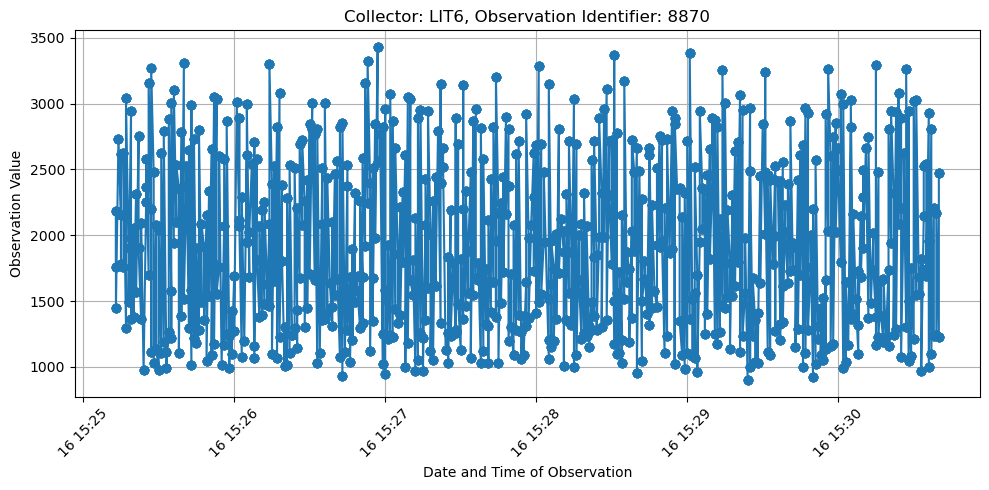

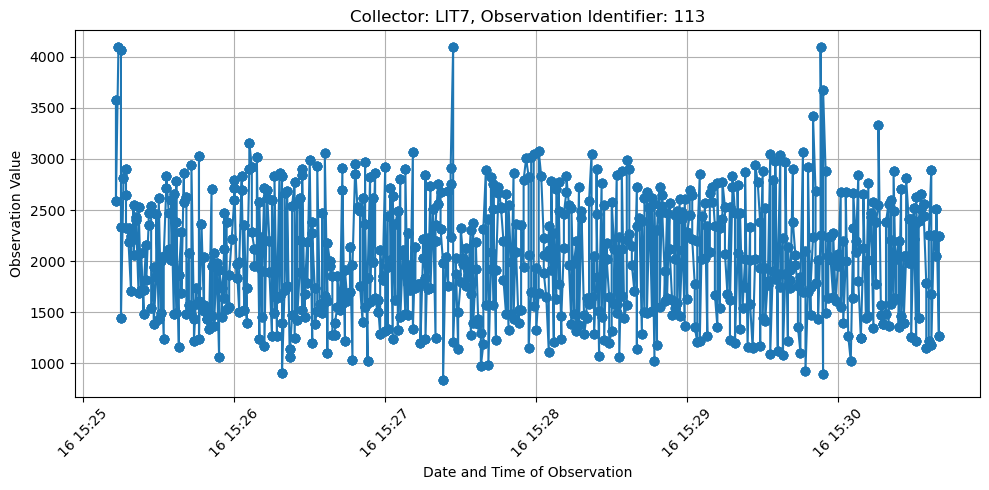

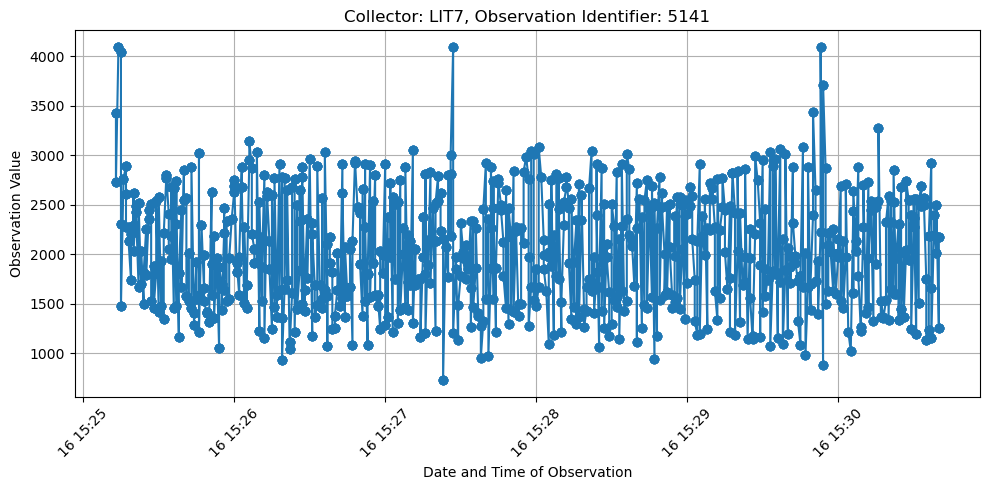

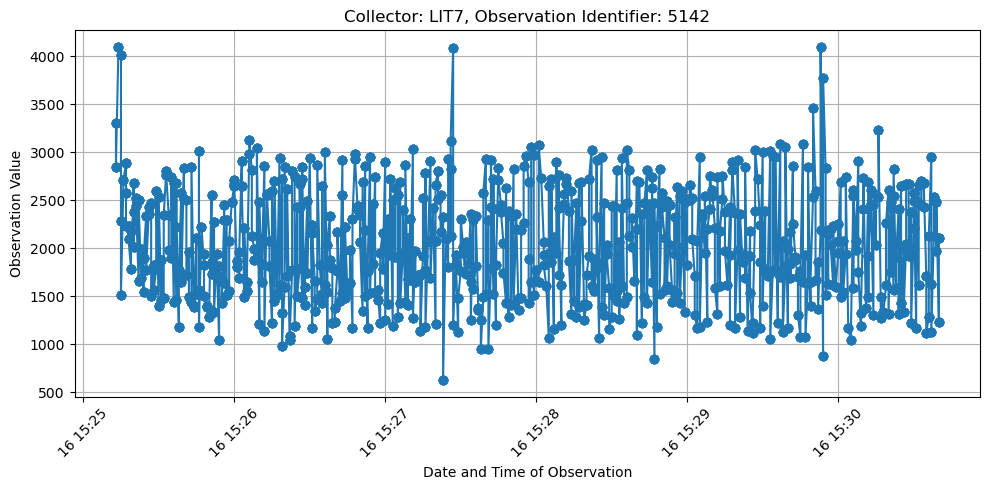

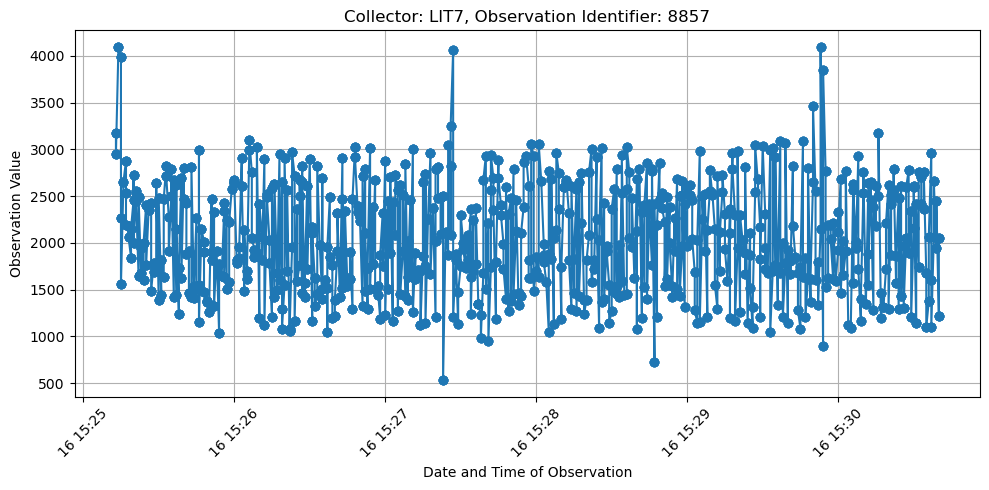

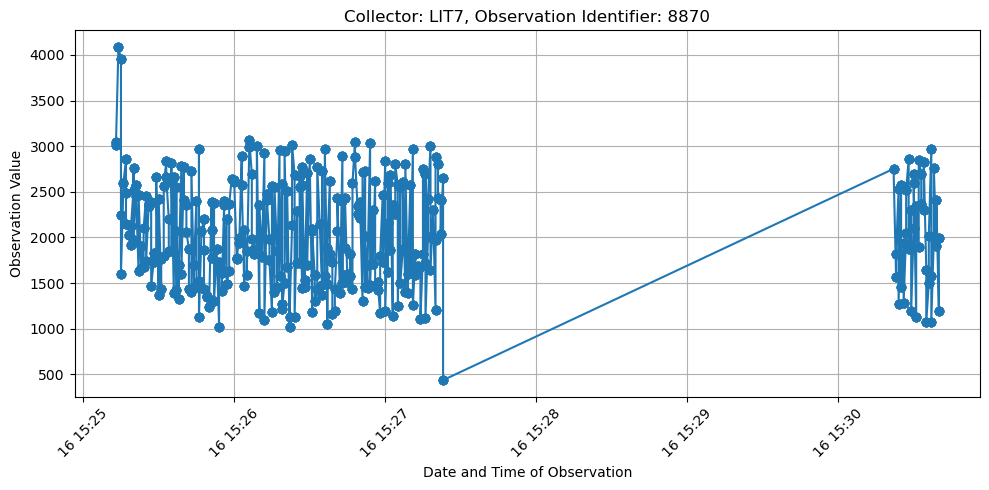

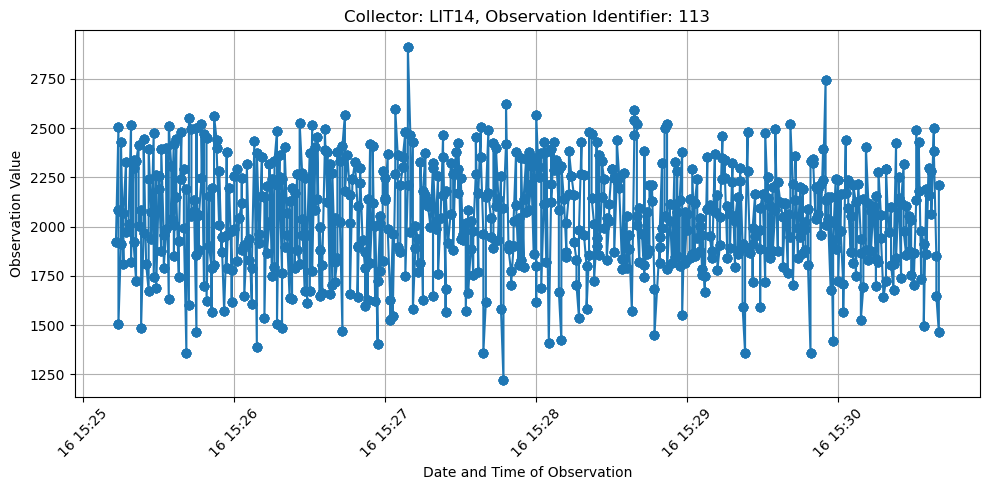

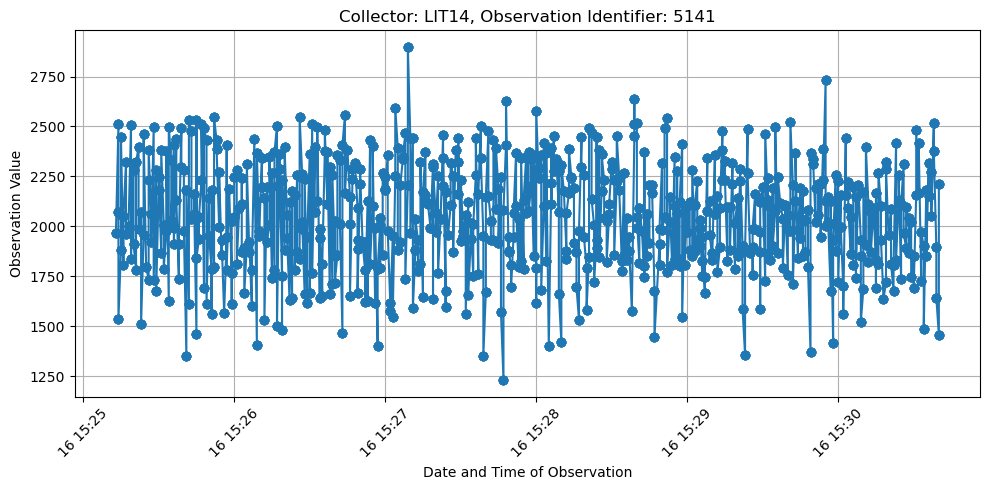

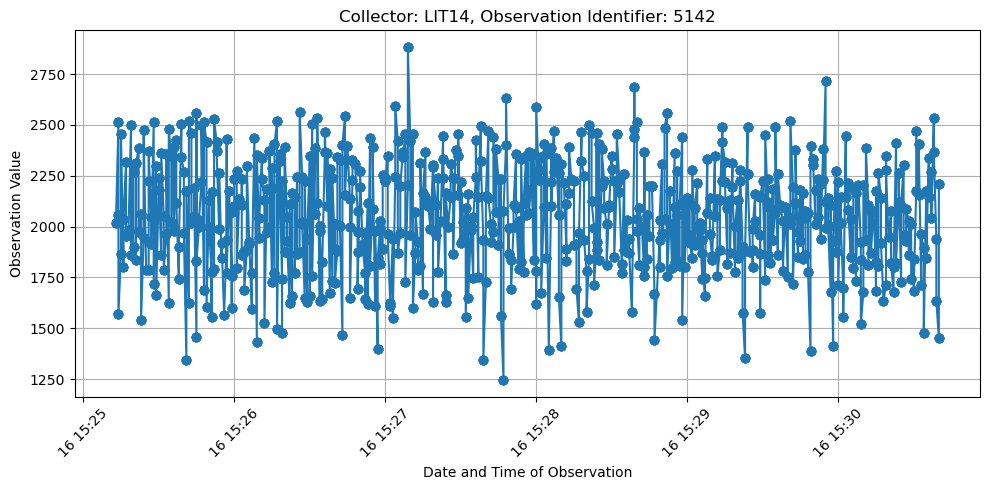

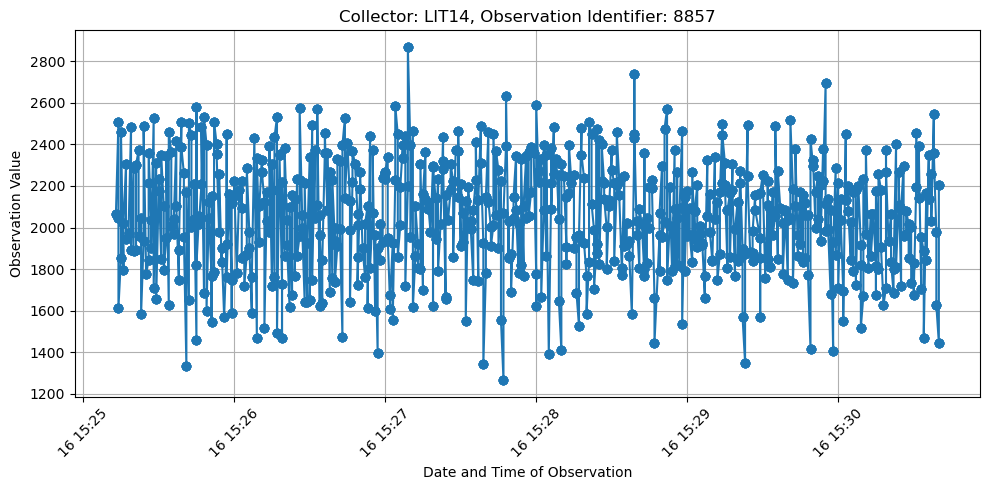

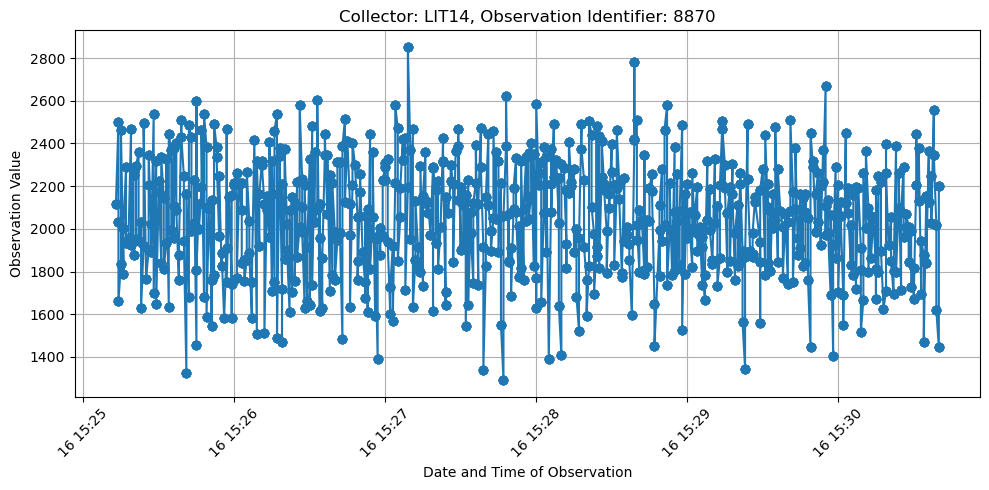

In [35]:
for collector in flattened_df['COLLECTOR_IDENTIFIER'].unique():
    collector_df = flattened_df[flattened_df['COLLECTOR_IDENTIFIER'] == collector]
    
    for obs_id in collector_df['OBSERVATION_IDENTIFIER'].unique():
        obs_df = collector_df[collector_df['OBSERVATION_IDENTIFIER'] == obs_id]
        
        plt.figure(figsize=(10, 5))
        plt.plot(obs_df['DATE_TIME_OF_THE_OBSERVATION'], obs_df['OBSERVATION_VALUE'], marker='o')
        plt.title(f'Collector: {collector}, Observation Identifier: {obs_id}')
        plt.xlabel('Date and Time of Observation')
        plt.ylabel('Observation Value')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

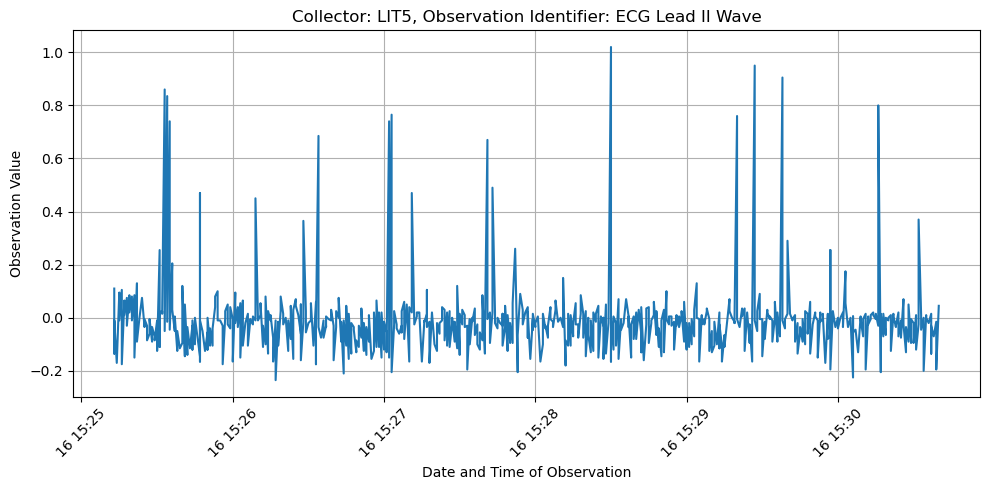

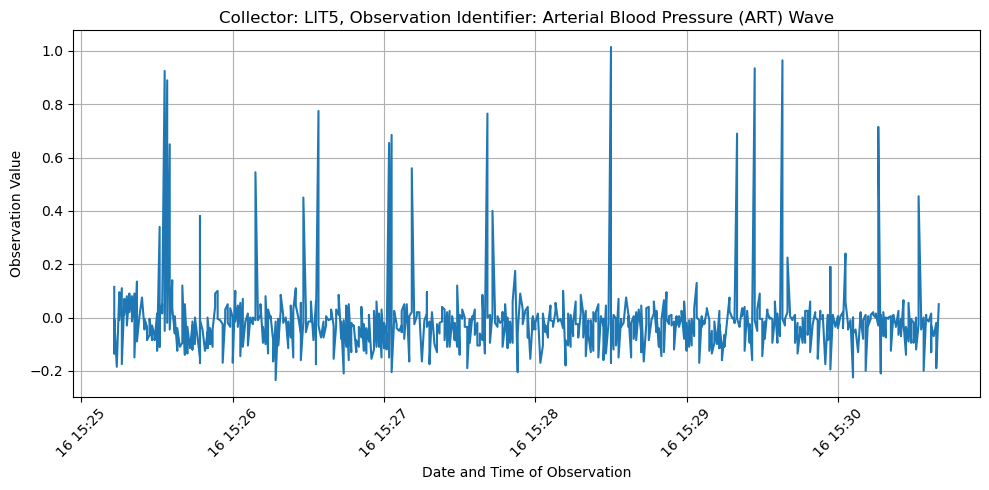

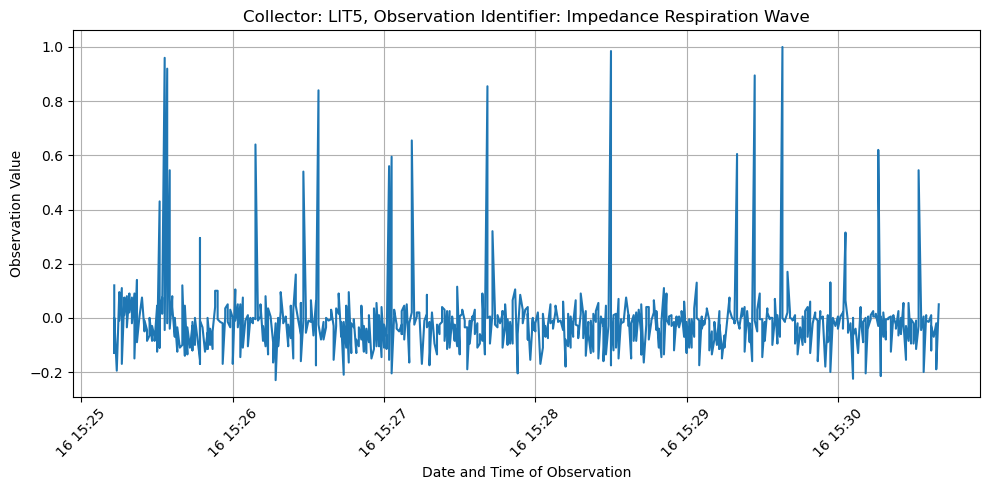

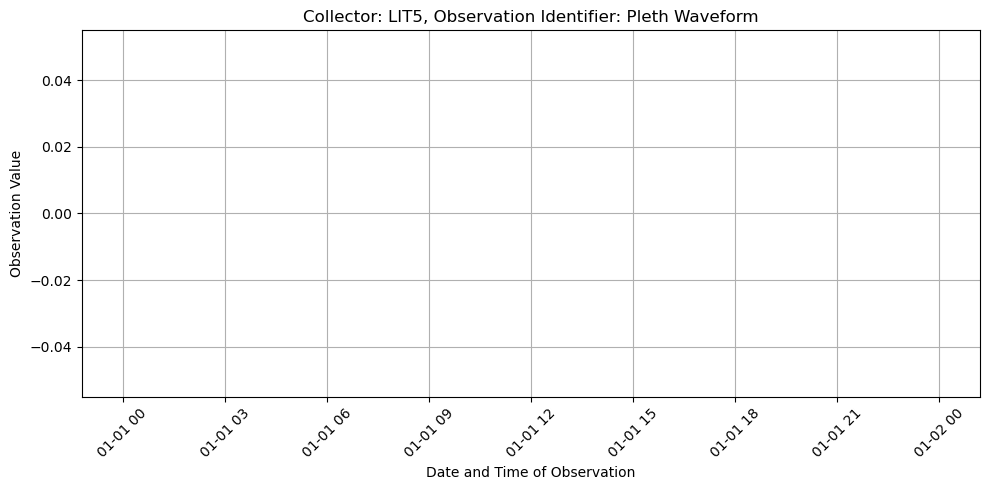

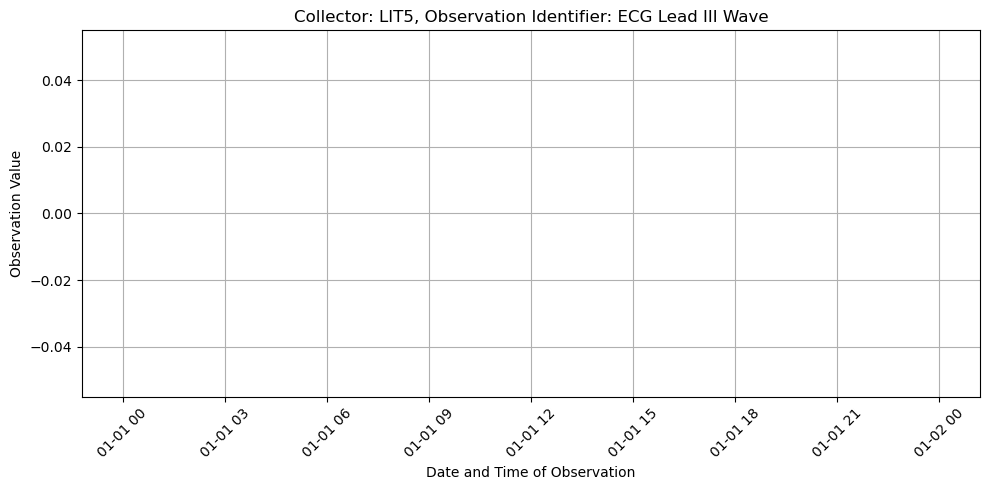

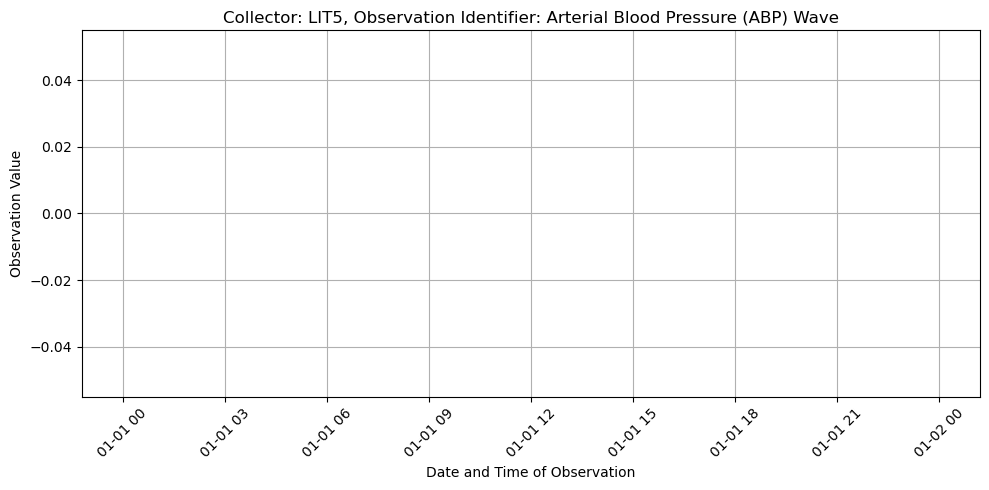

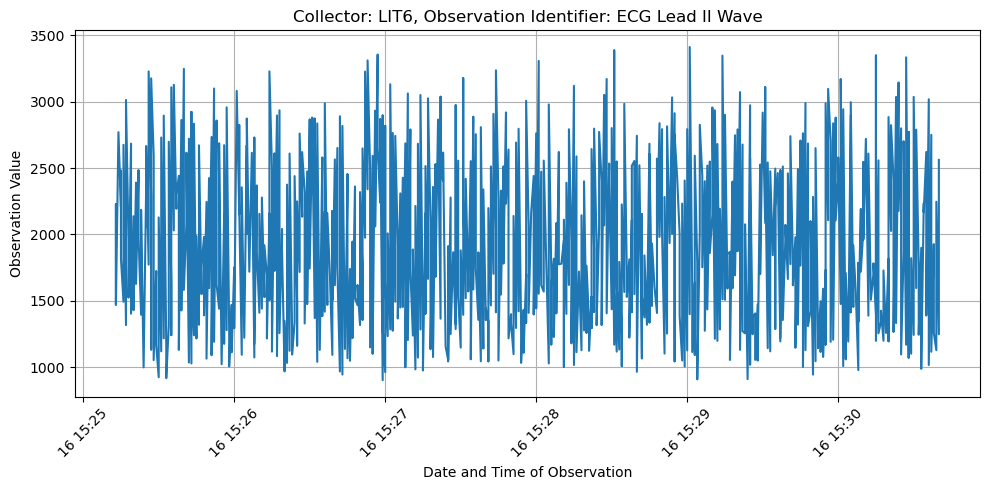

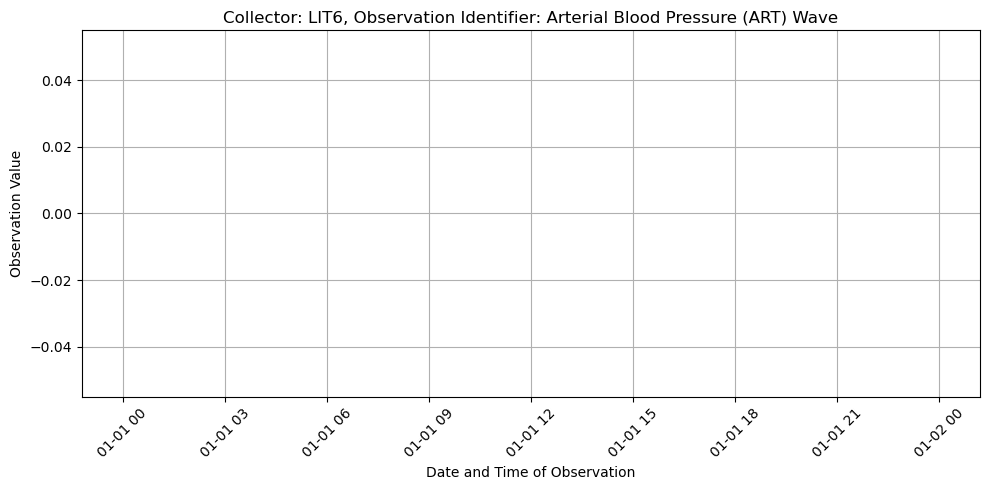

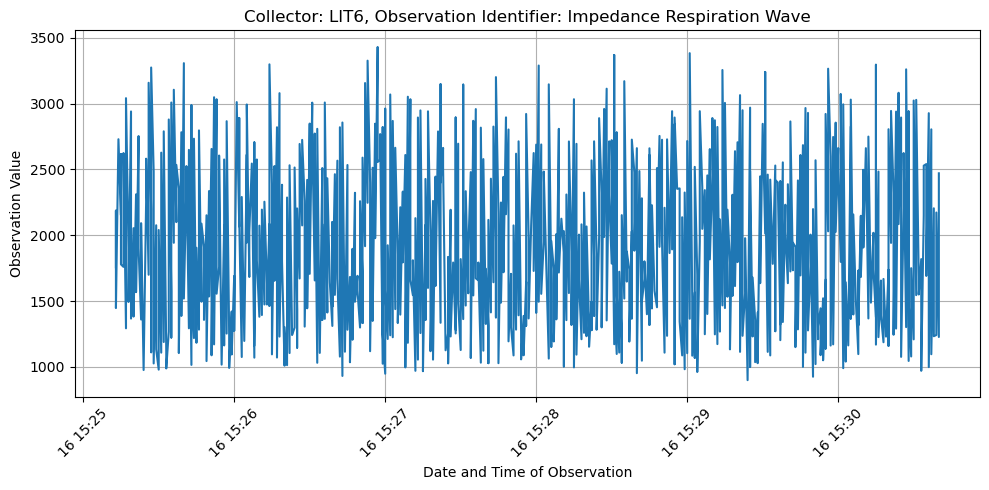

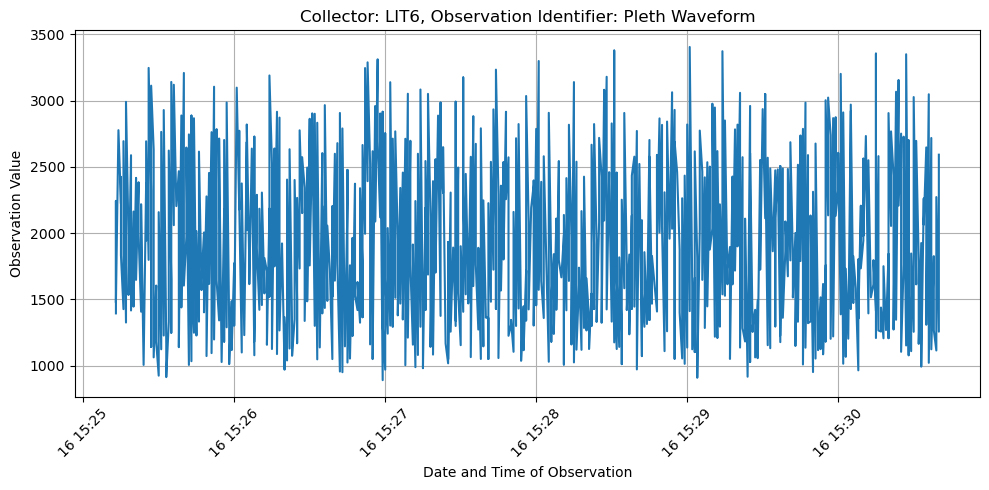

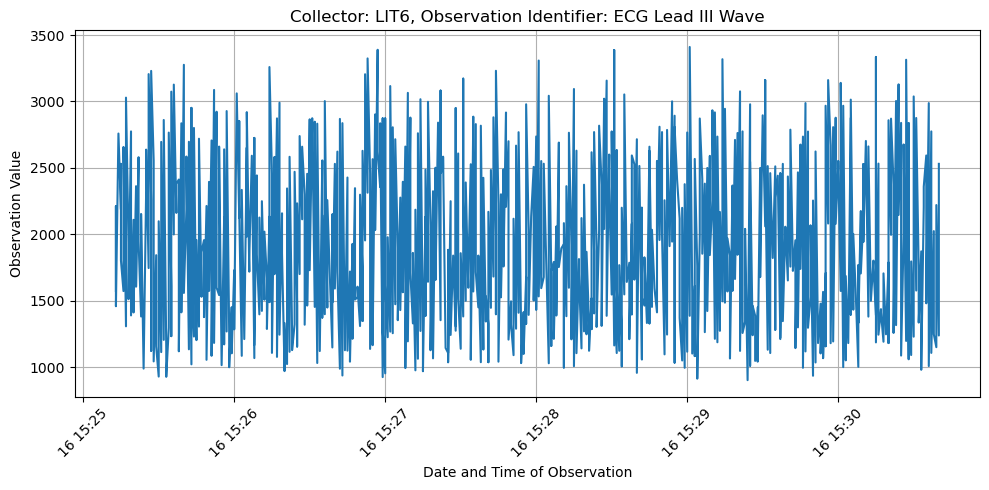

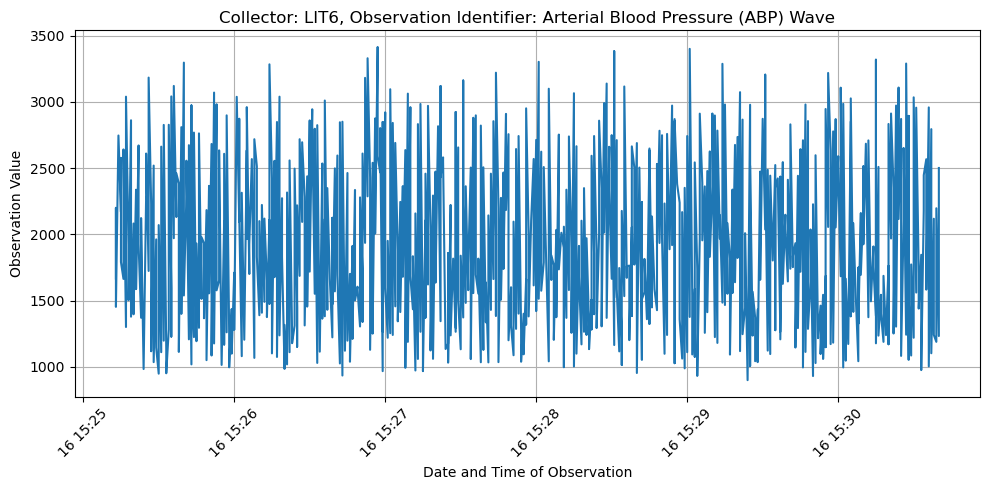

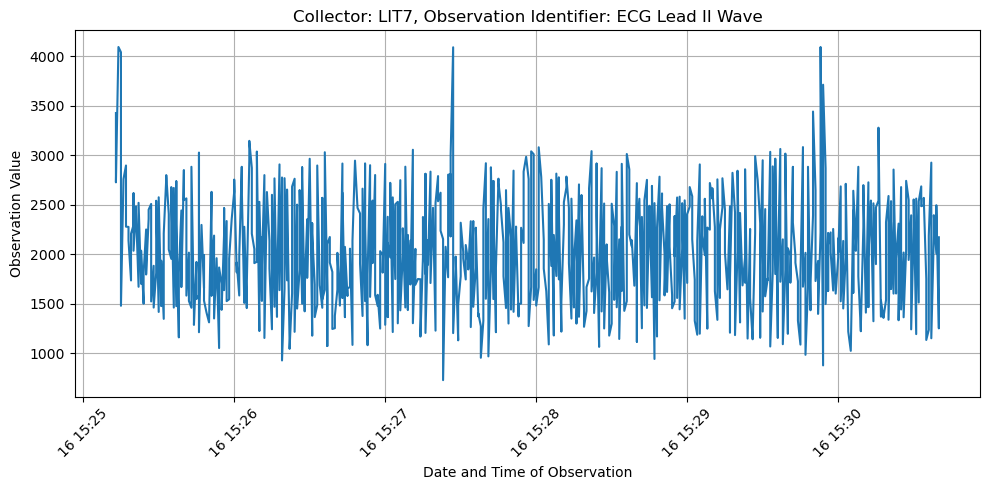

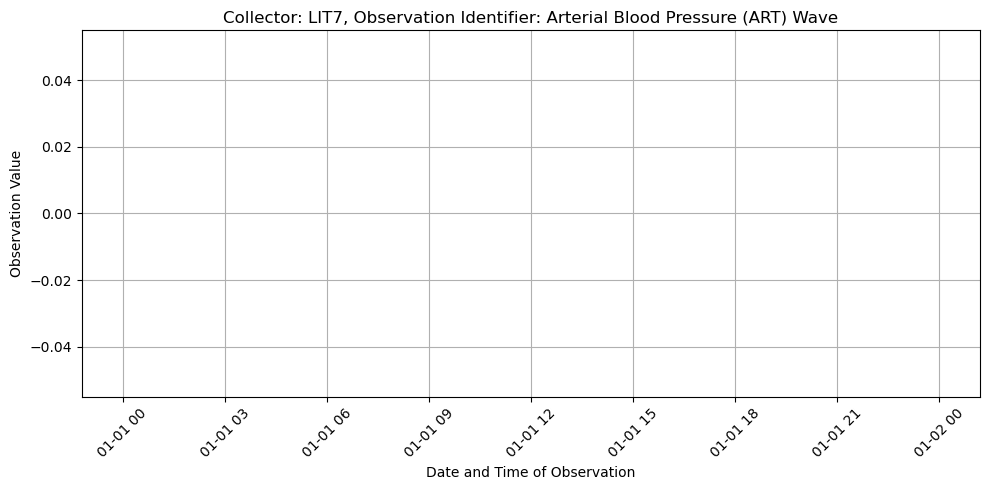

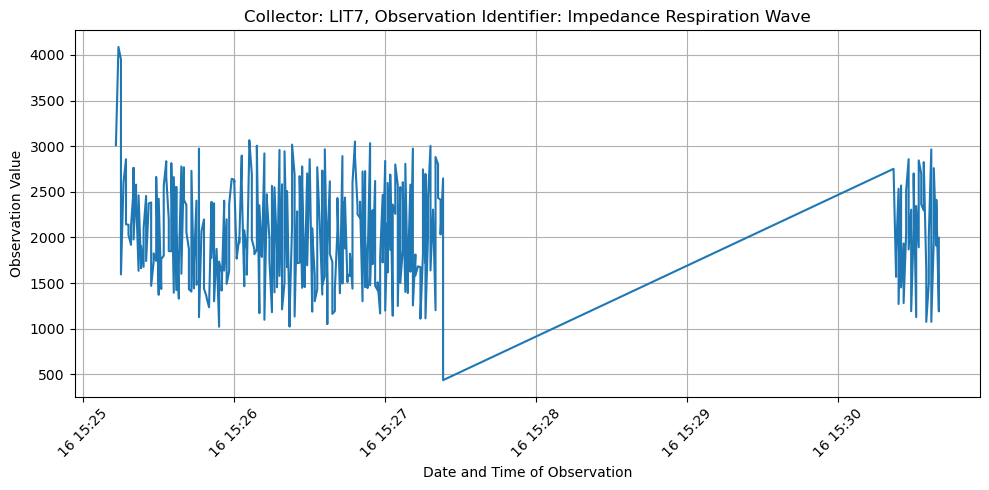

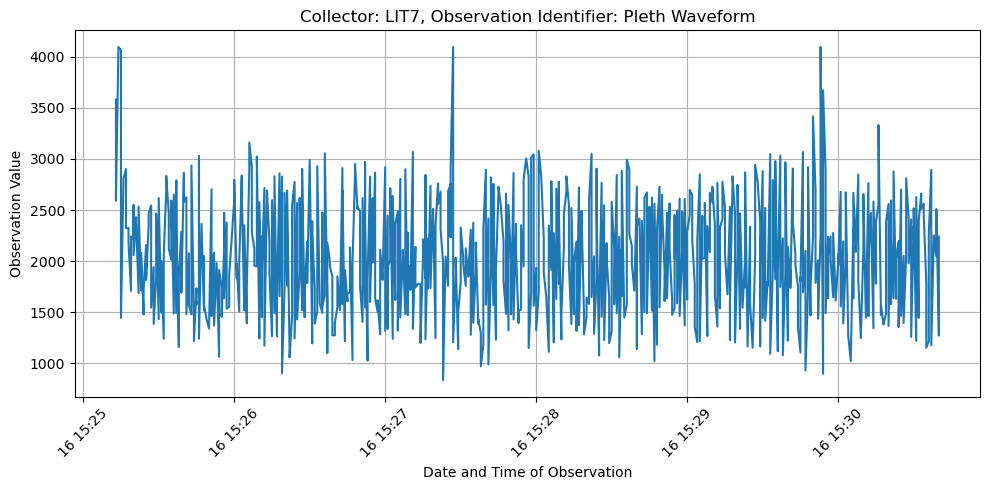

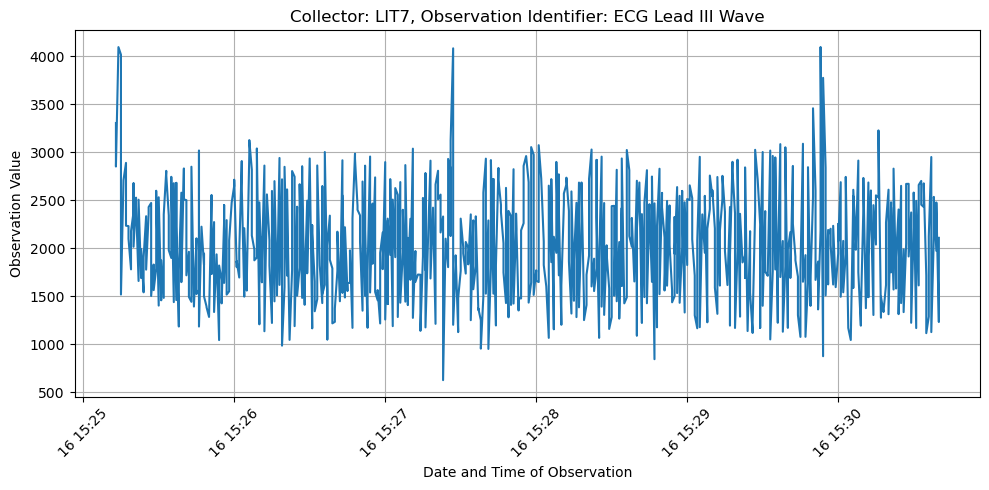

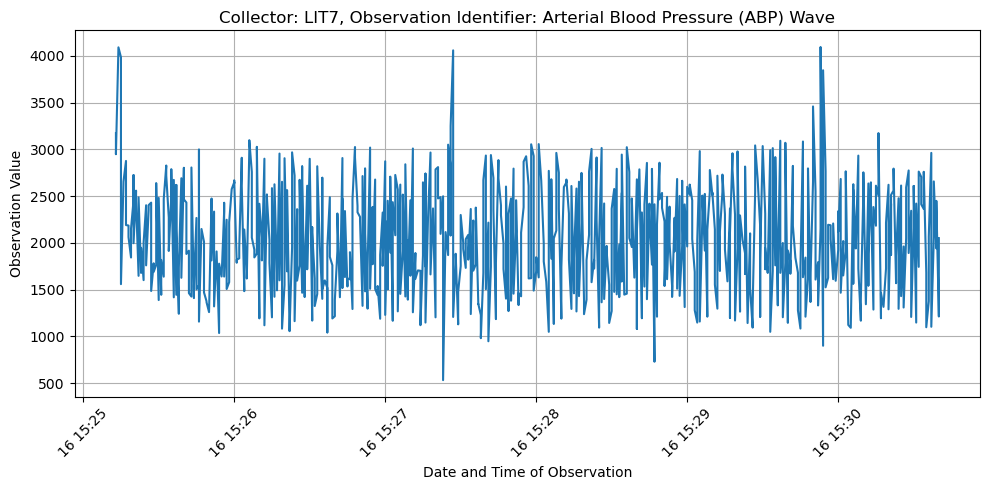

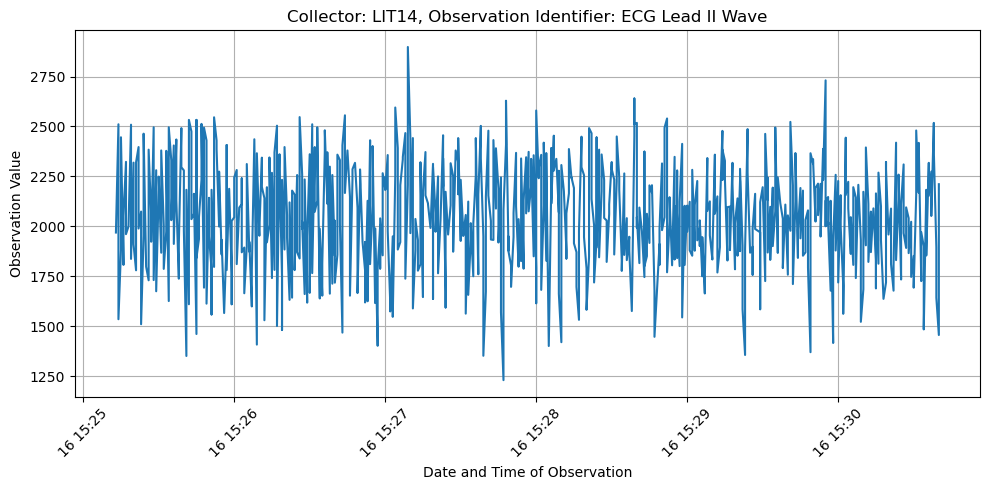

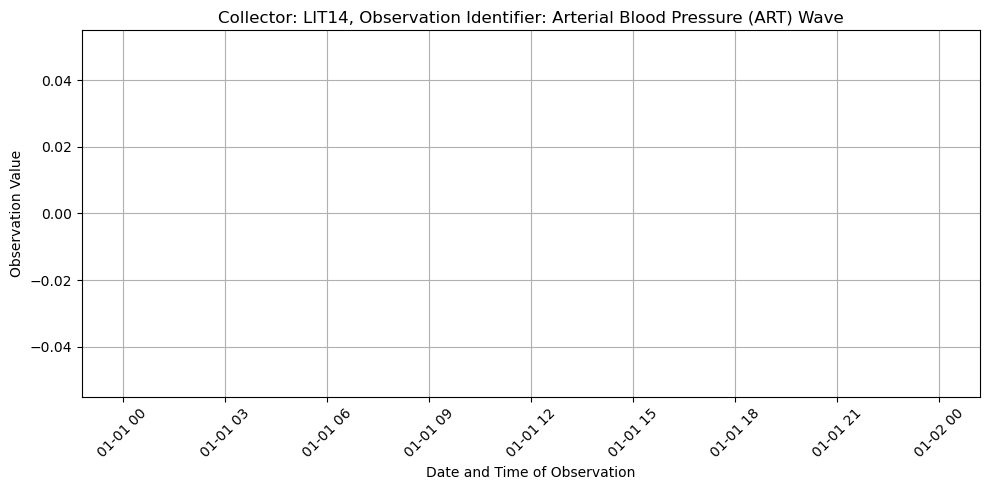

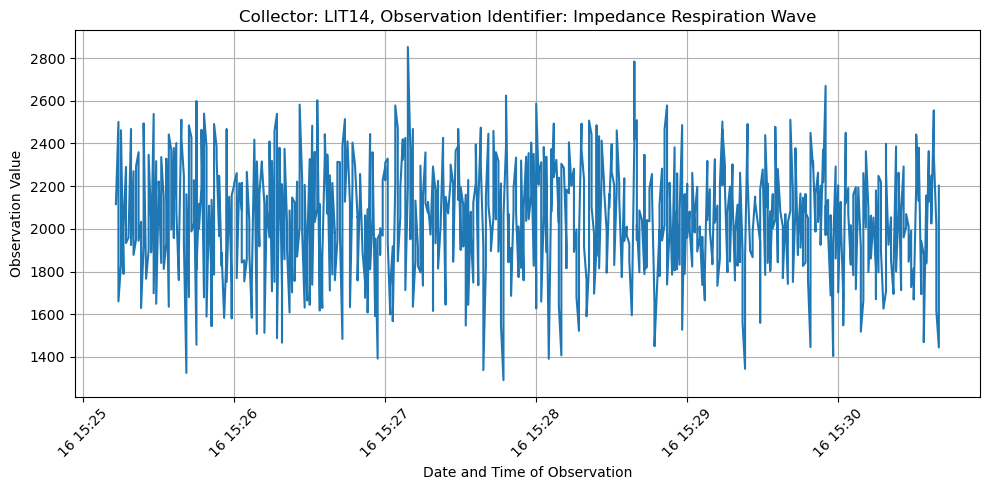

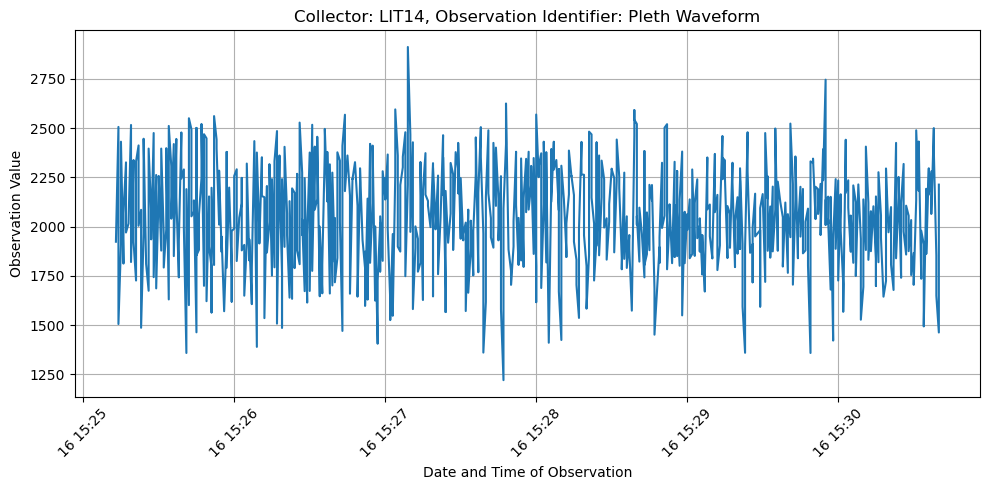

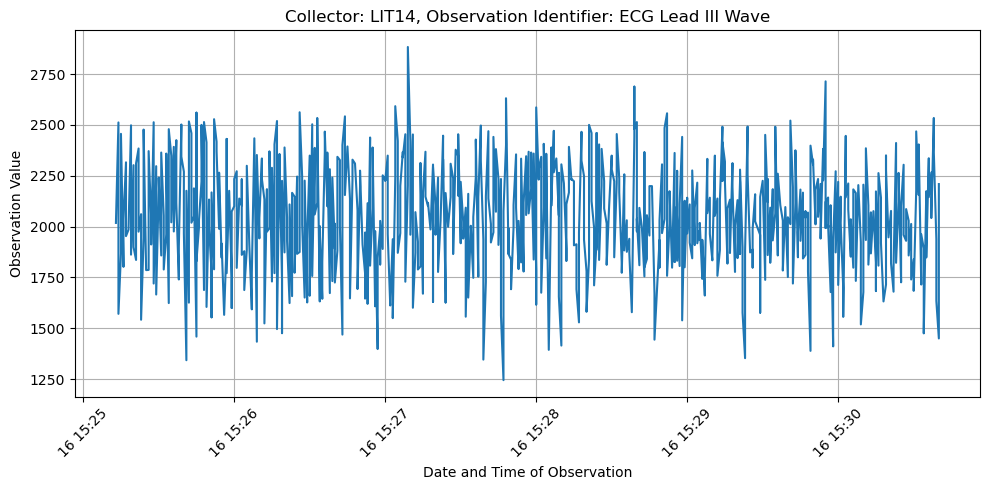

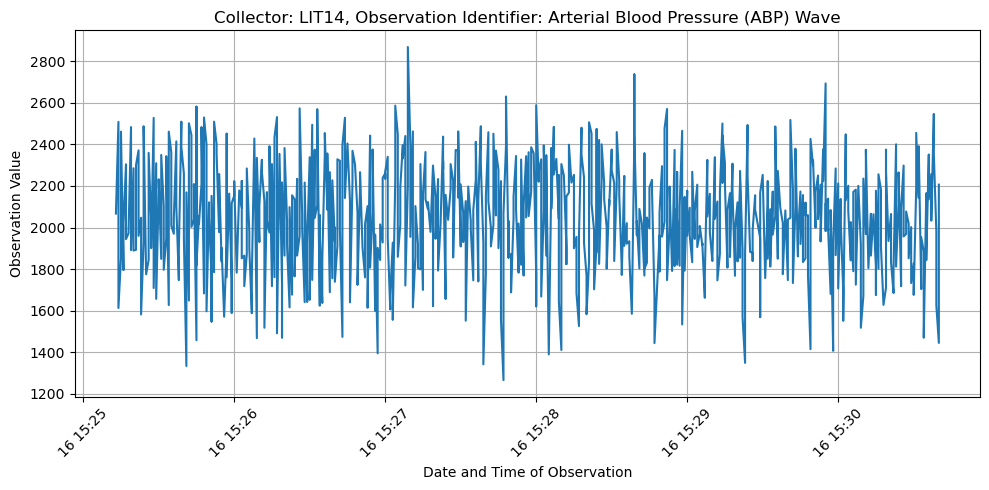

In [38]:

# Définir les variables à dessiner le graphe
observations_dict = {'5141': 'ECG Lead II Wave', '8858': 'Arterial Blood Pressure (ART) Wave', '8870': 'Impedance Respiration Wave', '113': 'Pleth Waveform', '5142': 'ECG Lead III Wave', '8857': 'Arterial Blood Pressure (ABP) Wave'}

df = final_df

# Fonction pour aplatir les listes et créer un nouveau DataFrame
def flatten_dataframe(df):
    records = []
    for idx, row in df.iterrows():
        dates = row['DATE_TIME_OF_THE_OBSERVATION']
        observation_values_list = '^'.join(row['OBSERVATION_VALUE'])

        observation_identifiers = row['OBSERVATION_IDENTIFIER']
        
        for date in dates:
            split_values = observation_values_list.split('^')
            for obs_id, value in zip(observation_identifiers, split_values):
                records.append({
                    'COLLECTOR_IDENTIFIER': row['COLLECTOR_IDENTIFIER'],
                    'DATE_TIME_OF_THE_OBSERVATION': pd.to_datetime(date),
                    'OBSERVATION_IDENTIFIER': obs_id,
                    'OBSERVATION_VALUE': float(value)
                })
    return pd.DataFrame(records)


flattened_df = flatten_dataframe(df)

for collector in flattened_df['COLLECTOR_IDENTIFIER'].unique():
    collector_df = flattened_df[flattened_df['COLLECTOR_IDENTIFIER'] == collector]
    
    for obs_id, obs_label in observations_dict.items():
        obs_df = collector_df[collector_df['OBSERVATION_IDENTIFIER'] == obs_id]
        
        plt.figure(figsize=(10, 5))
        plt.plot(obs_df['DATE_TIME_OF_THE_OBSERVATION'], obs_df['OBSERVATION_VALUE'])
        plt.title(f'Collector: {collector}, Observation Identifier: {obs_label}')
        plt.xlabel('Date and Time of Observation')
        plt.ylabel('Observation Value')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
